In [28]:
import xarray as xr
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [29]:
#make a barplots dir in figures
if not os.path.exists('figures/barplots'):
    os.makedirs('figures/barplots')

# Create mask

In [30]:
# Load arrays
arrays = {
    "ECMWF": xr.open_dataarray("outputs/Full Period/ECMWF_IMD/ELR_rpss_test_wk3-4.nc"),
    "GEFS": xr.open_dataarray("outputs/Full Period/GEFS_IMD/ELR_rpss_test_wk3-4.nc"),
    "IITM": xr.open_dataarray("outputs/Full Period/IITM_IMD/ELR_rpss_test_wk3-4.nc"),
}

# Store masks
masks_full = {
    "ECMWF": arrays["ECMWF"].mean(dim='bootstrap').isnull(),
    "GEFS": arrays["GEFS"].mean(dim='bootstrap').isnull(),
    "IITM": arrays["IITM"].mean(dim='bootstrap').isnull(),
}

arrays_common = {
    "ECMWF": xr.open_dataarray("outputs/Common Period/ECMWF_IMD/ELR_rpss_test_wk3-4.nc"),
    "GEFS": xr.open_dataarray("outputs/Common Period/GEFS_IMD/ELR_rpss_test_wk3-4.nc"),
    "IITM": xr.open_dataarray("outputs/Common Period/IITM_IMD/ELR_rpss_test_wk3-4.nc"),
}

# Store masks
masks_common = {
    "ECMWF": arrays_common["ECMWF"].mean(dim='bootstrap').isnull(),
    "GEFS": arrays_common["GEFS"].mean(dim='bootstrap').isnull(),
    "IITM": arrays_common["IITM"].mean(dim='bootstrap').isnull(),
    "MME": arrays_common["ECMWF"].mean(dim='bootstrap').isnull(),
    "2MME": arrays_common["ECMWF"].mean(dim='bootstrap').isnull()
}

## Bar plots for RPSS values

In [31]:
# Define the base directory
base_dir = "outputs"

# Define models and lead times
models = ["IITM_IMD", "GEFS_IMD", "ECMWF_IMD", "MME_IMD","2MME_IMD"]
architectures = ["ELR", "unet"]
lead_times = {"week 1": "rpss_test_wk1.nc", "week 2": "rpss_test_wk2.nc", "week 3-4": "rpss_test_wk3-4.nc"}

# Initialize storage for data
data_list = []

# Iterate through periods, models, and architectures
for period in ["Common Period", "Full period","MME","2MME"]:
    for model in models:
        
        if period in ["Common Period", "MME", "2MME"]:
            mask = masks_common[model.split("_")[0]]
        else:
            try:
                mask = masks_full[model.split("_")[0]]
            except KeyError:
                print(f"Mask for {model} not found. Skipping...")
                continue
        
        model_dir = os.path.join(base_dir, period, model)
        if not os.path.exists(model_dir):
            print(f"Model directory {model_dir} doesn't exist. Skipping...")
            continue  # Skip if model directory doesn't exist

        for lead_time, filename in lead_times.items():
            for arch in architectures:
                file_path = os.path.join(model_dir, f"{arch}_{filename}")  # Look for architecture-specific files
                
                if os.path.exists(file_path):
                    ds = xr.open_dataset(file_path)
                    print(f"Processing {file_path}...")
                    
                    # Rename variable if needed
                    if "__xarray_dataarray_variable__" in ds:
                        ds = ds.rename_vars({"__xarray_dataarray_variable__": "rpss"})

                    rpss = ds.transpose("bootstrap", "Y", "X").rpss

                    # Compute mean and std over bootstrap dimension
                    rpss_mean = rpss.mean(dim="bootstrap")
                    rpss_std = rpss.std(dim="bootstrap")

                    #rpss_mean = rpss

                    rpss_mean = rpss_mean.where(~mask)

                    # Store aggregated values
                    data_list.append({
                        "Model": model.replace("_IMD", ""),
                        "Architecture": arch,
                        "Lead Time": lead_time,
                        "RPSS Min": rpss_mean.min().values,
                        "RPSS Max": rpss_mean.max().values,
                        "RPSS": rpss_mean.values,
                        "Period": period
                    })

# Convert to DataFrame
df = pd.DataFrame(data_list)


Processing outputs\Common Period\IITM_IMD\ELR_rpss_test_wk1.nc...
Processing outputs\Common Period\IITM_IMD\unet_rpss_test_wk1.nc...
Processing outputs\Common Period\IITM_IMD\ELR_rpss_test_wk2.nc...
Processing outputs\Common Period\IITM_IMD\unet_rpss_test_wk2.nc...
Processing outputs\Common Period\IITM_IMD\ELR_rpss_test_wk3-4.nc...
Processing outputs\Common Period\IITM_IMD\unet_rpss_test_wk3-4.nc...
Processing outputs\Common Period\GEFS_IMD\ELR_rpss_test_wk1.nc...
Processing outputs\Common Period\GEFS_IMD\unet_rpss_test_wk1.nc...
Processing outputs\Common Period\GEFS_IMD\ELR_rpss_test_wk2.nc...
Processing outputs\Common Period\GEFS_IMD\unet_rpss_test_wk2.nc...
Processing outputs\Common Period\GEFS_IMD\ELR_rpss_test_wk3-4.nc...
Processing outputs\Common Period\GEFS_IMD\unet_rpss_test_wk3-4.nc...
Processing outputs\Common Period\ECMWF_IMD\ELR_rpss_test_wk1.nc...
Processing outputs\Common Period\ECMWF_IMD\unet_rpss_test_wk1.nc...
Processing outputs\Common Period\ECMWF_IMD\ELR_rpss_test_wk

## Full period plots

C:\Users\emile\AppData\Local\Temp\ipykernel_17220\3032497375.py:41: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['{:,.1%}'.format(x) for x in vals])
C:\Users\emile\AppData\Local\Temp\ipykernel_17220\3032497375.py:41: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['{:,.1%}'.format(x) for x in vals])


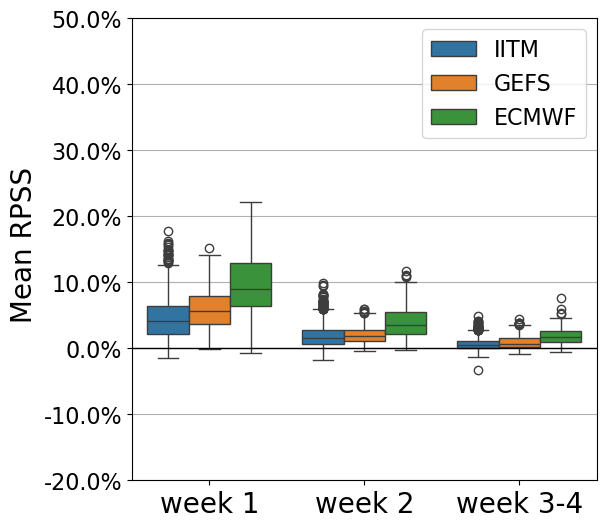

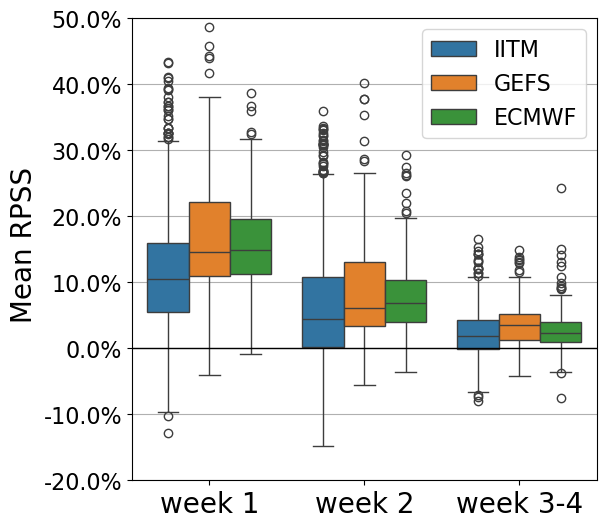

In [32]:
df_fp = df[df["Period"] == "Full period"]
architectures = ["ELR", "unet"]
# Define lead time order
lead_time_order = ["week 1", "week 2", "week 3-4"]

for arch in architectures:
    df_arch = df_fp[df_fp["Architecture"] == arch]

    # Assuming the DataFrame df has been created as in your code
    # Flatten the RPSS arrays and replicate the corresponding metadata
    plot_data = []

    # Loop over each entry in the DataFrame and flatten the RPSS values
    for index, row in df_arch.iterrows():
        # Flatten the RPSS array into a 1D array for the violin plot and drop nas
        rpss_flat = row["RPSS"].flatten()
        rpss_flat = rpss_flat[~np.isnan(rpss_flat)]
        
        # Replicate metadata for each flattened RPSS value
        model_repeated = [row["Model"]] * len(rpss_flat)
        lead_time_repeated = [row["Lead Time"]] * len(rpss_flat)
        
        # Append the flattened data to the list
        for rpss_val, model, lead_time in zip(rpss_flat, model_repeated, lead_time_repeated):
            plot_data.append({
                "RPSS": rpss_val,
                "Model": model,
                "Lead Time": lead_time
            })

    # Convert the list into a DataFrame for easy plotting
    plot_df = pd.DataFrame(plot_data)

    # Create the violin plot
    plt.figure(figsize=(6, 6))
    ax = sns.boxplot(data=plot_df, x="Lead Time", y="RPSS", hue="Model",
                        order=lead_time_order)
    # Customize the plot
    plt.ylim(-0.2, 0.5)
    vals = ax.get_yticks()
    ax.set_yticklabels(['{:,.1%}'.format(x) for x in vals])
    #make ticks big
    plt.yticks(fontsize=16)
    # Add 0 reference line
    plt.axhline(0, color='black', lw=1)
    #increase font size
    plt.xticks(fontsize=20)
    #make legend font size 20
    plt.legend(fontsize=16, loc='upper right')
    plt.ylabel(f" Mean RPSS", fontsize=20)
    plt.xlabel("")
    plt.grid(axis='y')
    plt.savefig(f"figures/barplots/Full_period_{arch}_plots.pdf", bbox_inches='tight')

## MME plots

C:\Users\emile\AppData\Local\Temp\ipykernel_17220\3564462155.py:39: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['{:,.1%}'.format(x) for x in vals])
C:\Users\emile\AppData\Local\Temp\ipykernel_17220\3564462155.py:39: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['{:,.1%}'.format(x) for x in vals])


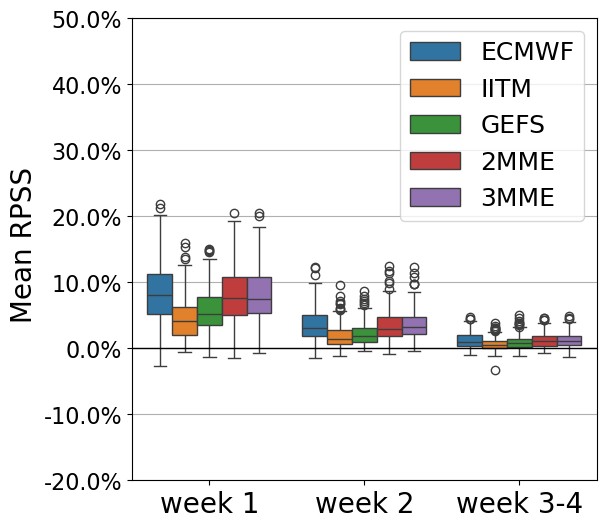

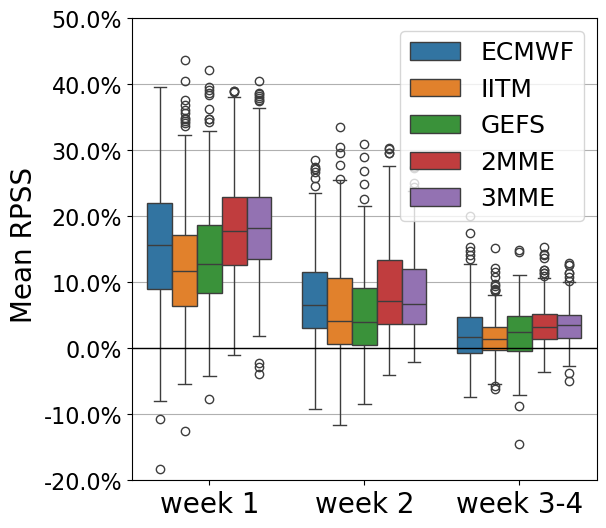

In [33]:
df_mm = df[(df["Period"] == "MME") | (df["Period"] == "Common Period") | (df["Period"] == "2MME")]
architectures = ["ELR", "unet"]
for arch in architectures:
    df_arch = df_mm[df_mm["Architecture"] == arch]

    # Assuming the DataFrame df has been created as in your code
    # Flatten the RPSS arrays and replicate the corresponding metadata
    plot_data = []

    # Loop over each entry in the DataFrame and flatten the RPSS values
    for index, row in df_arch.iterrows():
        # Flatten the RPSS array into a 1D array for the violin plot
        rpss_flat = row["RPSS"].flatten()
        rpss_flat = rpss_flat[~np.isnan(rpss_flat)]

        
        # Replicate metadata for each flattened RPSS value
        model_repeated = [row["Model"]] * len(rpss_flat)
        lead_time_repeated = [row["Lead Time"]] * len(rpss_flat)
        
        # Append the flattened data to the list
        for rpss_val, model, lead_time in zip(rpss_flat, model_repeated, lead_time_repeated):
            plot_data.append({
                "RPSS": rpss_val,
                "Model": "3MME" if model =='MME' else model,
                "Lead Time": lead_time
            })

    # Convert the list into a DataFrame for easy plotting
    plot_df = pd.DataFrame(plot_data)

    # Create the violin plot
    plt.figure(figsize=(6, 6))
    ax = sns.boxplot(data=plot_df, x="Lead Time", y="RPSS", hue="Model",
                        order=lead_time_order, hue_order=["ECMWF", "IITM", "GEFS", "2MME", "3MME"])
    # Customize the plot
    plt.ylim(-0.2, 0.5)
    vals = ax.get_yticks()
    ax.set_yticklabels(['{:,.1%}'.format(x) for x in vals])
    #make ticks big
    plt.yticks(fontsize=16)
    # Add 0 reference line
    plt.axhline(0, color='black', lw=1)
    #increase font size
    plt.xticks(fontsize=20)
    #make legend font size 20
    plt.legend(fontsize=18, loc='best')
    plt.ylabel(f" Mean RPSS", fontsize=20)
    plt.xlabel("")
    plt.grid(axis='y')
    plt.savefig(f"figures/barplots/MME_{arch}_plots.pdf", bbox_inches='tight', dpi=300)

C:\Users\emile\AppData\Local\Temp\ipykernel_17220\3659420640.py:38: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['{:,.1%}'.format(x) for x in vals])


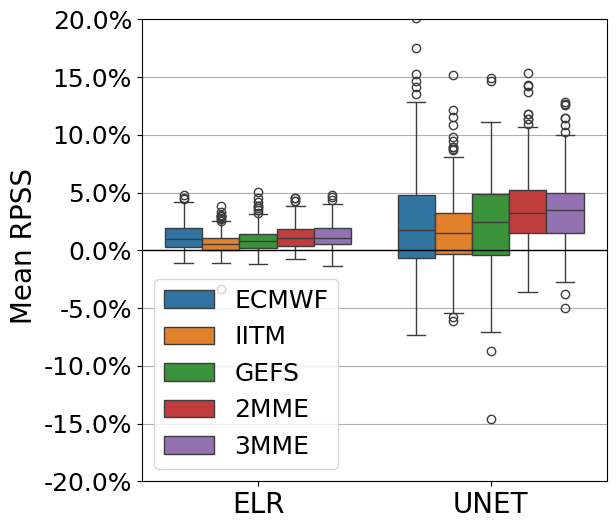

In [34]:
df_mm = df[(df["Period"] == "MME") | (df["Period"] == "Common Period") | (df["Period"] == "2MME")]
architectures = ["ELR", "unet"]

df_arch = df_mm[df_mm["Lead Time"] == "week 3-4"]

# Assuming the DataFrame df has been created as in your code
# Flatten the RPSS arrays and replicate the corresponding metadata
plot_data = []

# Loop over each entry in the DataFrame and flatten the RPSS values
for index, row in df_arch.iterrows():
    # Flatten the RPSS array into a 1D array for the violin plot
    rpss_flat = row["RPSS"].flatten()
    
    # Replicate metadata for each flattened RPSS value
    model_repeated = [row["Model"]] * len(rpss_flat)
    lead_time_repeated = [row["Lead Time"]] * len(rpss_flat)
    
    # Append the flattened data to the list
    for rpss_val, model, lead_time in zip(rpss_flat, model_repeated, lead_time_repeated):
        plot_data.append({
            "Architecture": row["Architecture"].upper(),
            "RPSS": rpss_val,
            "Model": "3MME" if model =='MME' else model,
        })

# Convert the list into a DataFrame for easy plotting
plot_df = pd.DataFrame(plot_data)

# Create the violin plot
plt.figure(figsize=(6, 6))
ax = sns.boxplot(data=plot_df, x="Architecture", y="RPSS", hue="Model",
                        hue_order=["ECMWF", "IITM", "GEFS", "2MME", "3MME"]
                    )
# Customize the plot
plt.ylim(-0.2, 0.2)
vals = ax.get_yticks()
ax.set_yticklabels(['{:,.1%}'.format(x) for x in vals])

#make yticks big
plt.yticks(fontsize=18)

# Add 0 reference line
plt.axhline(0, color='black', lw=1)
#increase font size
plt.xticks(fontsize=20)
#make legend font size 20
plt.legend(fontsize=18, loc='best')
plt.ylabel(f" Mean RPSS", fontsize=20)
plt.xlabel("")
plt.grid(axis='y')
plt.savefig(f"figures/barplots/MME_RPSS_wk3-4.pdf", bbox_inches='tight', dpi=300)

# Homogemous Climate Regions

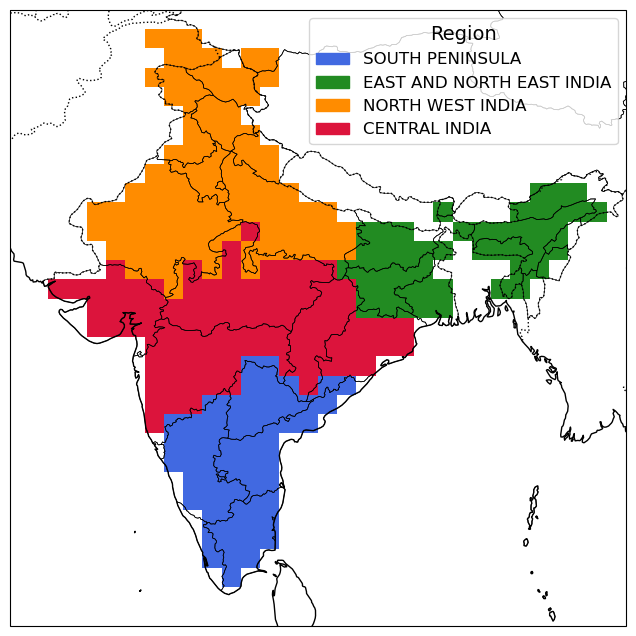

In [35]:
import geopandas as gpd
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import rasterio
from rasterio.features import geometry_mask
from matplotlib.patches import Patch
from matplotlib import colors

# Step 1: Load the shapefile with all Indian states
shapefile_path = 'shapes/sd_boundary.shp'  # Replace with the path to your shapefile
gdf = gpd.read_file(shapefile_path)

# Step 2: Define the 1°x1° lat/lon grid
lat = np.arange(6.5, 38.5, 1)  # From 6°N to 37°N, 0.5° steps
lon = np.arange(66.5, 98.5, 1)  # From 68°E to 98°E, 0.5° steps

# Reverse the latitude to ensure proper orientation (higher latitudes are at the top)
lat = lat[::-1]

# Initialize region mask
region_mask = xr.DataArray(
    np.zeros((len(lat), len(lon)), dtype=int),
    coords={"lat": lat, "lon": lon},
    dims=("lat", "lon"),
    name="region_mask"
)

# Step 3: Create a mapping for region names to region IDs (e.g., 'SOUTH PENINSULA' to 1)
region_mapping = {
    'SOUTH PENINSULA': 1,
    'EAST AND NORTH EAST INDIA': 2,
    'NORTH WEST INDIA': 3,
    'CENTRAL INDIA': 4,
    # Add more mappings as needed based on your shapefile's REGION_CODE values
}

# Step 4: Convert the shapefile geometries to a raster mask
raster_mask = np.zeros_like(region_mask.values, dtype=int)

# Iterate over the states and assign the corresponding region IDs based on REGION_CODE
for idx, row in gdf.iterrows():
    region_code = row['region_cod']  # Use the REGION_CODE column directly
    
    # If the region_code is in the mapping, use the mapped integer
    region_id = region_mapping.get(region_code, np.nan)  # Default to 0 if not found in the mapping
    
    # Create the mask for the state using rasterio
    state_geometry = row['geometry']
    mask = geometry_mask([state_geometry], transform=rasterio.transform.from_origin(lon[0] - 0.5, lat[0] + 0.5, 1, 1), invert=True, out_shape=(len(lat), len(lon)))
    
    # Assign the region ID to the raster mask
    raster_mask[mask] = region_id

# Assign the rasterized mask to the xarray DataArray
region_mask.values = raster_mask

# Step 5: Plot using Cartopy
fig = plt.figure(figsize=(10, 8))
ax = plt.axes(projection=ccrs.PlateCarree())

# Create a custom colormap where NaN values are white
cmap = colors.ListedColormap([ 'white', 'royalblue', 'forestgreen', 'darkorange', 'crimson'])

# Plot the region mask using imshow with proper extent
img = ax.imshow(region_mask.values, extent=[lon.min(), lon.max(), lat.min(), lat.max()],
                origin="upper", cmap=cmap, interpolation='nearest')

# Create a simple legend with manually defined colors for each region
handles = [
    Patch(color='royalblue', label='SOUTH PENINSULA'),
    Patch(color='forestgreen', label='EAST AND NORTH EAST INDIA'),
    Patch(color='darkorange', label='NORTH WEST INDIA'),
    Patch(color='crimson', label='CENTRAL INDIA'),
]

# Add the legend to the plot
ax.legend(handles=handles, title="Region", loc='upper right', fontsize=12, title_fontsize=14)

# Set the extent of the map to show the Indian domain
ax.set_extent([lon.min(), lon.max(), lat.min(), lat.max()], crs=ccrs.PlateCarree())
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.STATES, linewidth=0.5)

# Save the figure with proper resolution and tight bounding box
plt.savefig("figures/barplots/region_mask.pdf", bbox_inches='tight', dpi=300)

# Show the plot
plt.show()


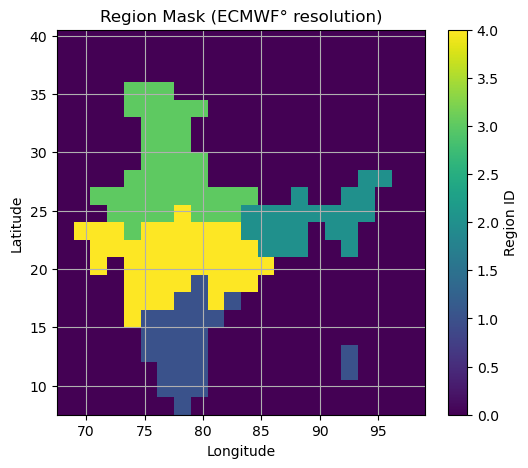

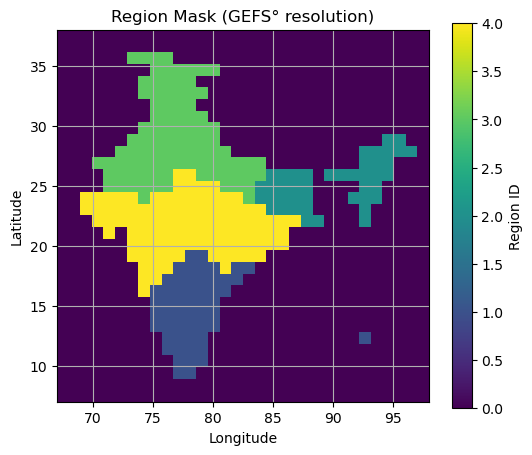

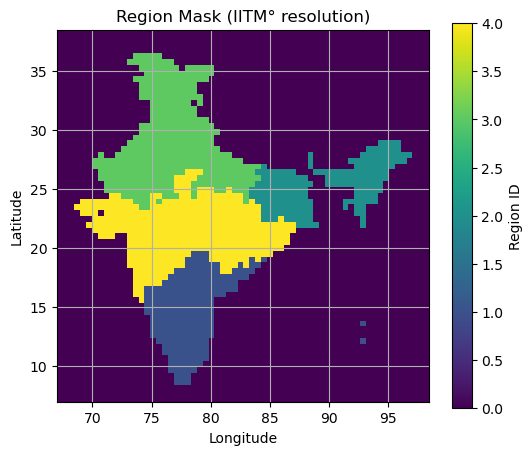

In [36]:
import xarray as xr
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from rasterio.features import geometry_mask
from rasterio.transform import from_origin
from shapely.geometry import box

# Load shapefile
gdf = gpd.read_file('shapes/sd_boundary.shp')
if gdf.crs != "EPSG:4326":
    gdf = gdf.to_crs("EPSG:4326")

# Region code mapping
region_mapping = {
    'SOUTH PENINSULA': 1,
    'EAST AND NORTH EAST INDIA': 2,
    'NORTH WEST INDIA': 3,
    'CENTRAL INDIA': 4,
}

# Load arrays
arrays = {
    "ECMWF": xr.open_dataarray("outputs/Full Period/ECMWF_IMD/unet_rpss_test_wk3-4.nc"),
    "GEFS": xr.open_dataarray("outputs/Full Period/GEFS_IMD/unet_rpss_test_wk3-4.nc"),
    "IITM": xr.open_dataarray("outputs/Full Period/IITM_IMD/unet_rpss_test_wk3-4.nc"),
}

# Store masks
masks = {}

for label, array in arrays.items():
    y = array['Y'].values
    x = array['X'].values

    # Determine resolution
    xres = np.abs(x[1] - x[0])
    yres = np.abs(y[1] - y[0])

    # Make sure Y is descending
    if y[0] < y[-1]:
        y = y[::-1]
        array = array.sel(Y=y)

    lat, lon = y, x

    region_mask = xr.DataArray(
        np.zeros((len(lat), len(lon)), dtype=int),
        coords={"Y": lat, "X": lon},
        dims=("Y", "X"),
        name=f"region_mask_{label.replace('.', '_')}"
    )

    raster_mask = np.zeros_like(region_mask.values, dtype=int)

    transform = from_origin(
        lon[0] - xres / 2,
        lat[0] + yres / 2,
        xres,
        yres
    )

    for _, row in gdf.iterrows():
        region_code = row['region_cod']
        region_id = region_mapping.get(region_code, np.nan)
        geometry = row['geometry']

        if not geometry.intersects(box(x.min(), y.min(), x.max(), y.max())):
            continue  # Skip geometry if outside grid

        mask = geometry_mask(
            [geometry],
            transform=transform,
            invert=True,
            out_shape=(len(lat), len(lon))
        )

        raster_mask[mask] = region_id

    region_mask.values = raster_mask
    masks[label] = region_mask

    # Plot for verification
    plt.figure(figsize=(6, 5))
    plt.imshow(raster_mask, origin='upper', extent=(lon.min(), lon.max(), lat.min(), lat.max()))
    plt.title(f"Region Mask ({label}° resolution)")
    plt.colorbar(label='Region ID')
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.grid(True)
    plt.show()


## Plots for each region

### Full Period

C:\Users\emile\AppData\Local\Temp\ipykernel_17220\4196143022.py:79: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right", fontsize=16)
C:\Users\emile\AppData\Local\Temp\ipykernel_17220\4196143022.py:79: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right", fontsize=16)
C:\Users\emile\AppData\Local\Temp\ipykernel_17220\4196143022.py:79: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right", fontsize=16)
C:\Users\emile\AppData\Local\Temp\ipykernel_17220\4196143022.py:91: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks(

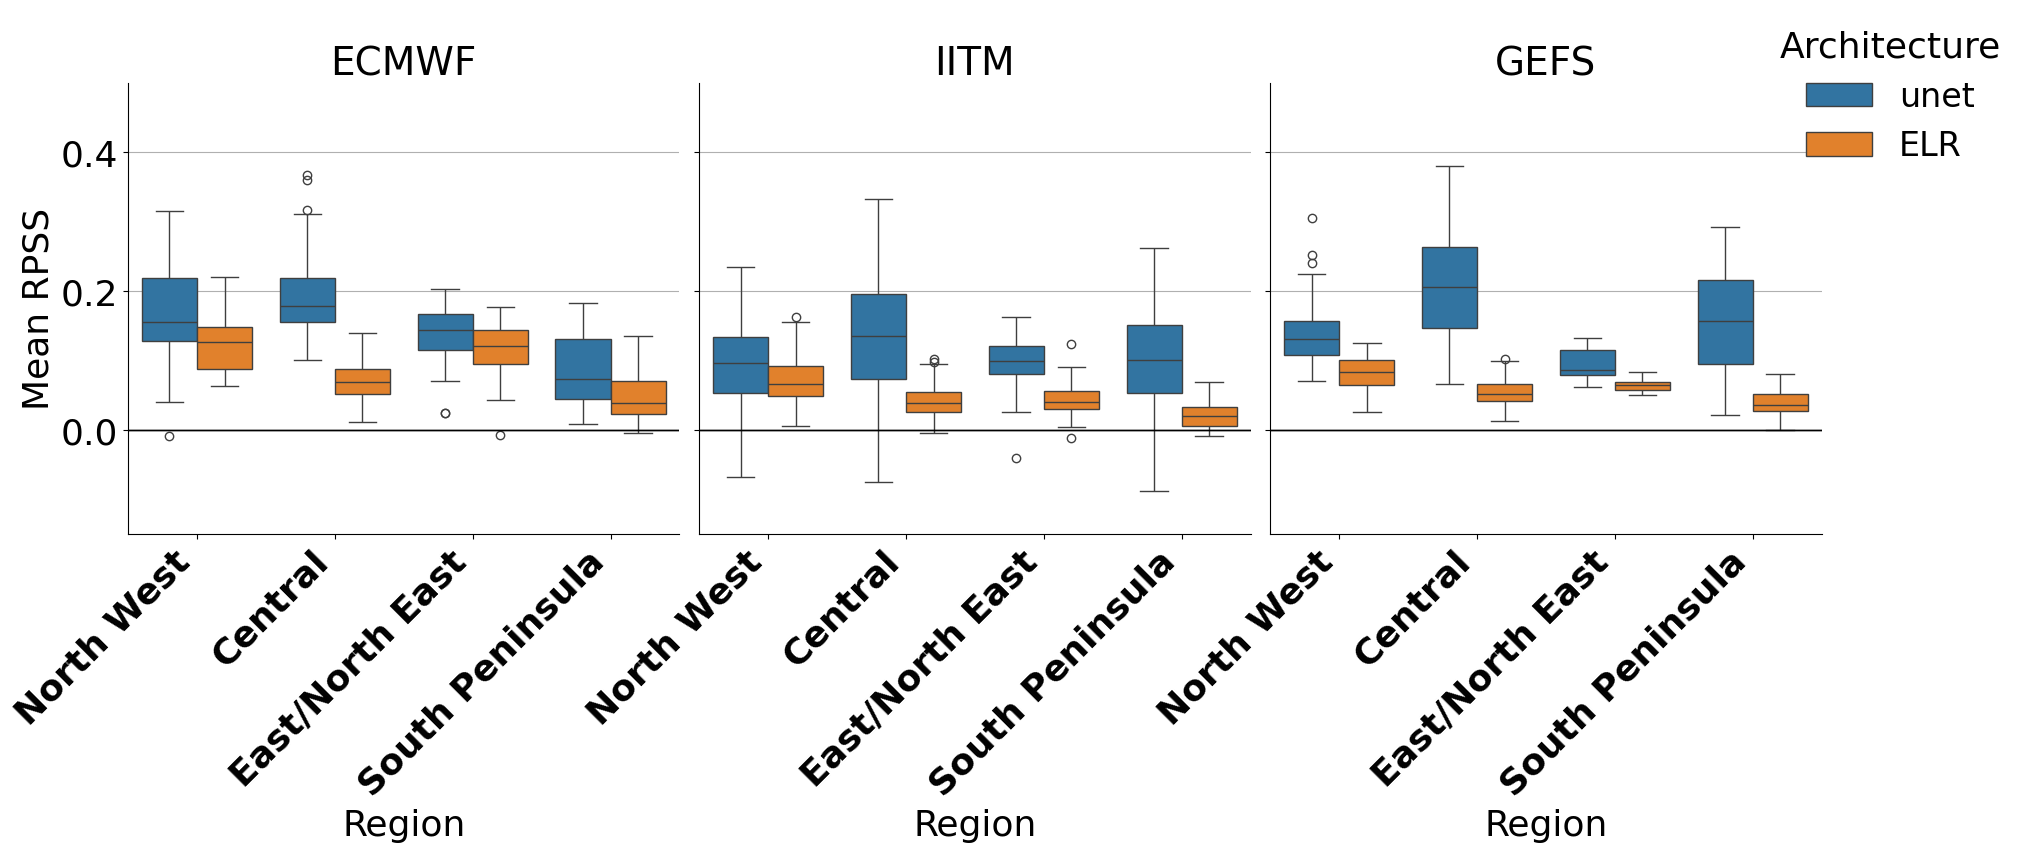

C:\Users\emile\AppData\Local\Temp\ipykernel_17220\4196143022.py:79: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right", fontsize=16)
C:\Users\emile\AppData\Local\Temp\ipykernel_17220\4196143022.py:79: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right", fontsize=16)
C:\Users\emile\AppData\Local\Temp\ipykernel_17220\4196143022.py:79: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right", fontsize=16)
C:\Users\emile\AppData\Local\Temp\ipykernel_17220\4196143022.py:91: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks(

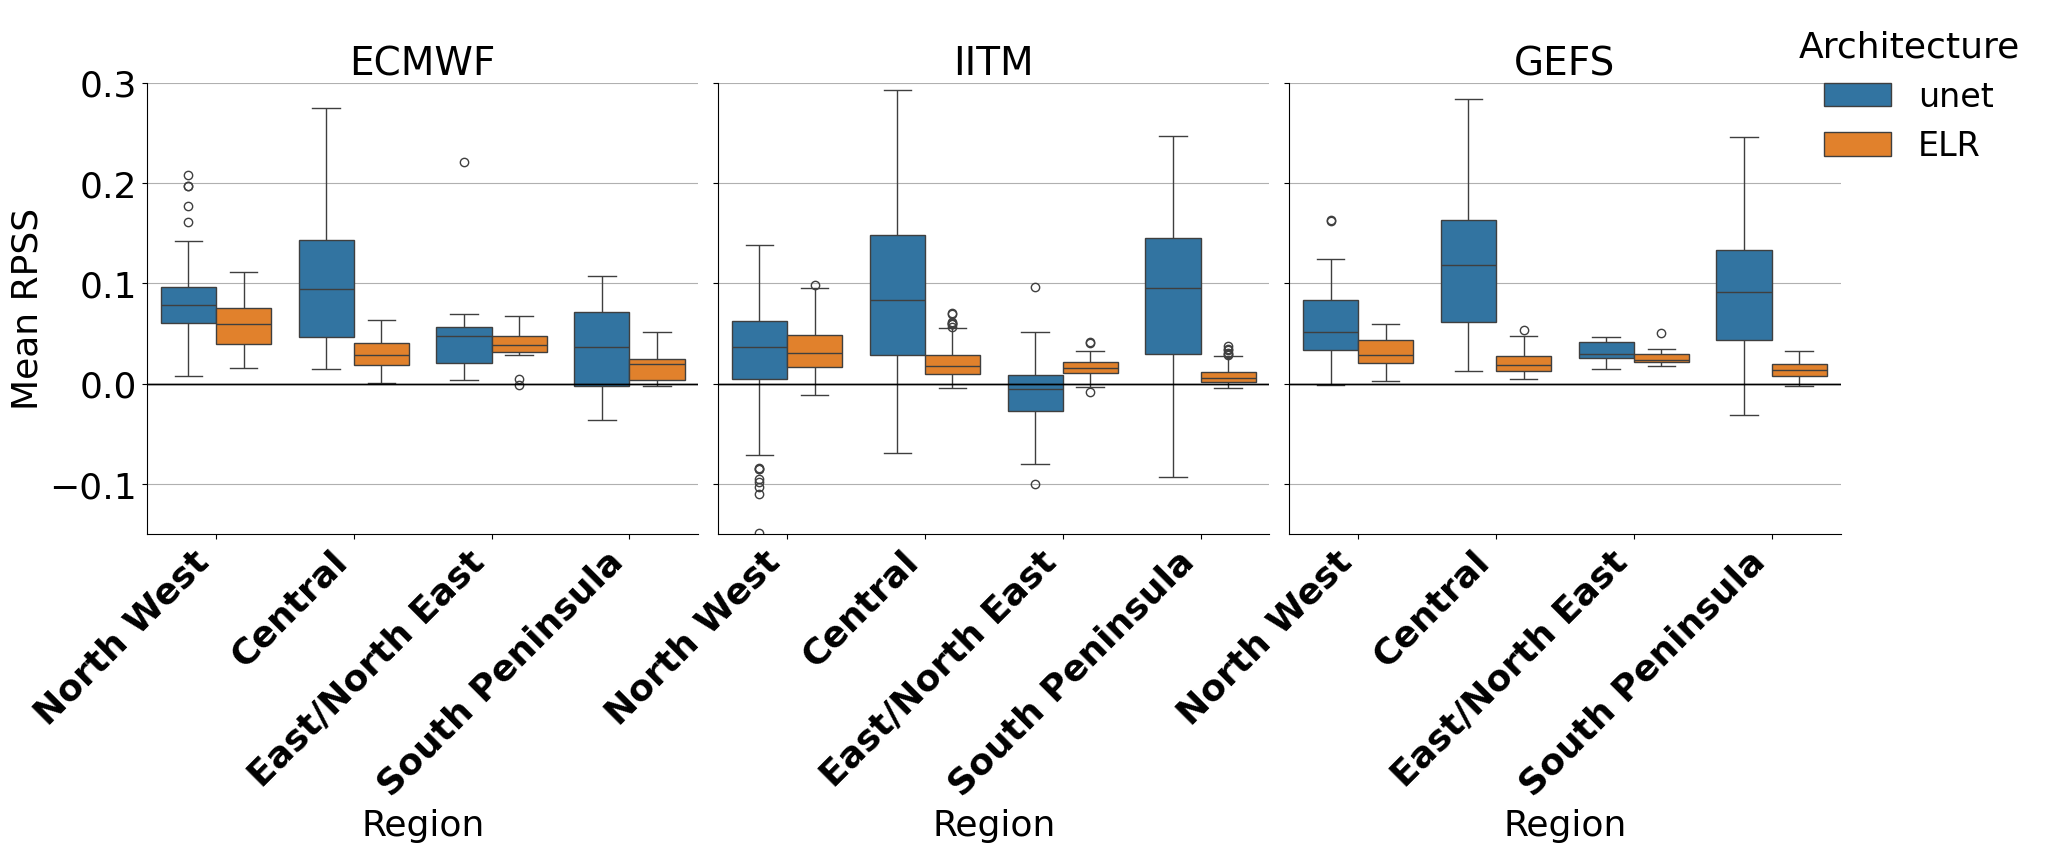

C:\Users\emile\AppData\Local\Temp\ipykernel_17220\4196143022.py:79: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right", fontsize=16)
C:\Users\emile\AppData\Local\Temp\ipykernel_17220\4196143022.py:79: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right", fontsize=16)
C:\Users\emile\AppData\Local\Temp\ipykernel_17220\4196143022.py:79: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right", fontsize=16)
C:\Users\emile\AppData\Local\Temp\ipykernel_17220\4196143022.py:91: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks(

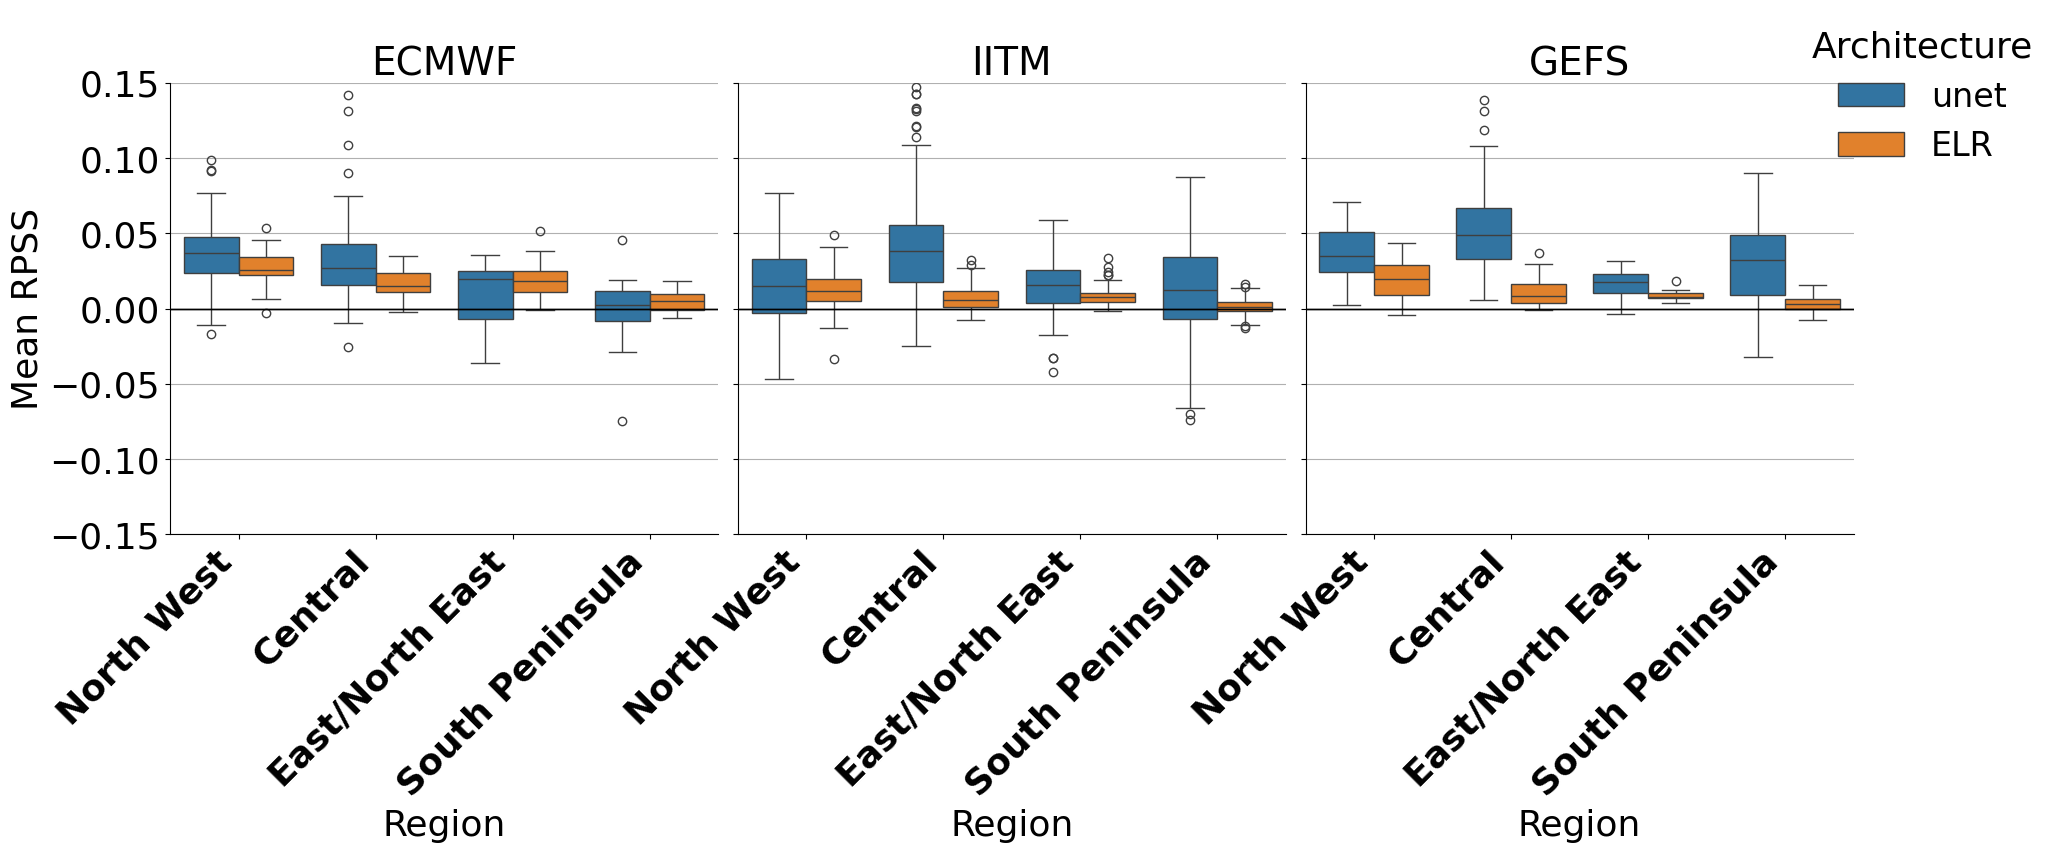

In [37]:
# Shortened region names
region_names = {
    1: 'South Peninsula',
    2: 'East/North East',
    3: 'North West',
    4: 'Central'
}

# Define lead times and models
lead_time_order = ["week 1", "week 2", "week 3-4"]
architectures = ["ELR", "unet"]
models = ["ECMWF", "IITM", "GEFS"]

# Iterate through each lead time
for lead_time in lead_time_order:
    plot_data = []

    for model in models:
        for arch in architectures:
            df_arch = df_fp[
                (df_fp["Architecture"] == arch) &
                (df_fp["Model"] == model) &
                (df_fp["Lead Time"] == lead_time)
            ]

            for _, row in df_arch.iterrows():
                rpss_values = row["RPSS"]
                region_values = masks[model].values

                for i in range(rpss_values.shape[0]):
                    for j in range(rpss_values.shape[1]):
                        region_id = region_values[i, j]
                        region_name = region_names.get(region_id, "Unknown")
                        rpss_val = rpss_values[i, j]

                        if np.isnan(rpss_val) or region_name == "Unknown":
                            continue

                        plot_data.append({
                            "RPSS": rpss_val,
                            "Region": region_name,
                            "Model": model,
                            "Lead Time": lead_time,
                            "Architecture": arch
                        })

    # Convert and clean
    plot_df = pd.DataFrame(plot_data)

    # Aggregate RPSS
    aggregated_df = plot_df.groupby(["Region", "Model", "Architecture"]).agg(
        RPSS_mean=("RPSS", "mean")).reset_index()

    # Facet by model
    g = sns.FacetGrid(
        plot_df,
        col="Model",
        sharey=True,
        height=6,
        aspect=1.
    )
    g.map_dataframe(
        sns.boxplot,
        x="Region",
        y="RPSS",
        hue="Architecture",
        hue_order=["unet", "ELR"],
        palette="tab10"
    )

    # Adjust axes and fonts
    g.set_titles(col_template="{col_name}", size=28)
    g.set_axis_labels("Region", "Mean RPSS")
    g.set_xlabels("Region", size=26)
    g.set_ylabels("Mean RPSS", size=26)

    for ax in g.axes.flat:
        ax.axhline(0, color="black", lw=1)
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right", fontsize=16)
        ax.tick_params(axis='y', labelsize=26)
        ax.grid(axis='y')

    # Legend
    g.add_legend(title="Architecture", title_fontsize=26, fontsize=24, loc='upper right')
    g._legend.set_title("Architecture", prop={"size": 26})
    for text in g._legend.texts:
        text.set_fontsize(24)
    
    for ax in g.axes.flat:
        ax.axhline(0, color="black", lw=1)
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right", fontsize=26, fontweight='bold')



    # Title
    g.fig.subplots_adjust(top=0.85)

    # Y-limits by lead time
    if lead_time == "week 3-4":
        g.set(ylim=(-0.15, 0.15))
    elif lead_time == "week 2":
        g.set(ylim=(-0.15, 0.3))
    else:
        g.set(ylim=(-0.15, 0.5))

    # Save and show
    g.savefig(f"figures/barplots/facet_region_bar_{lead_time.replace(' ', '_')}.pdf", bbox_inches='tight', dpi=300)
    plt.show()
    plt.close()


### MME

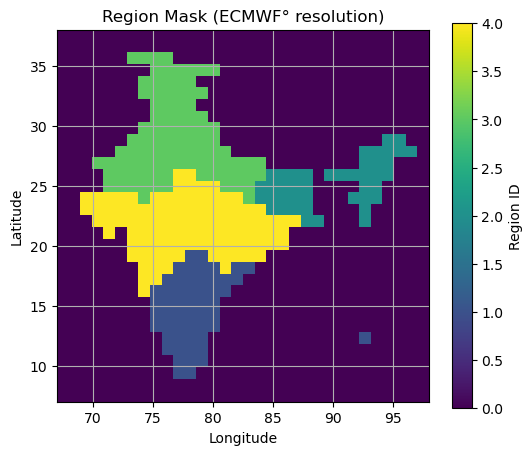

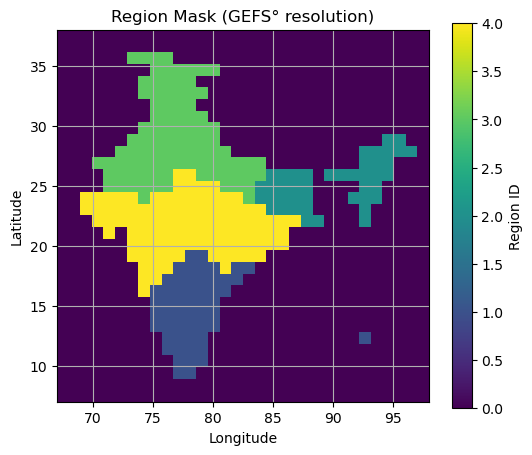

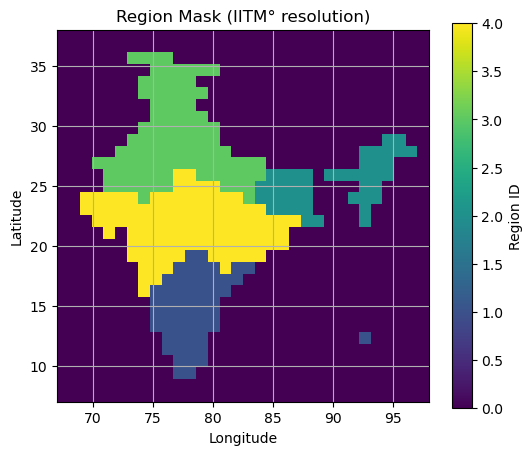

In [38]:
import xarray as xr
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from rasterio.features import geometry_mask
from rasterio.transform import from_origin
from shapely.geometry import box

# Load shapefile
gdf = gpd.read_file('shapes/sd_boundary.shp')
if gdf.crs != "EPSG:4326":
    gdf = gdf.to_crs("EPSG:4326")

# Region code mapping
region_mapping = {
    'SOUTH PENINSULA': 1,
    'EAST AND NORTH EAST INDIA': 2,
    'NORTH WEST INDIA': 3,
    'CENTRAL INDIA': 4,
}

# Load arrays
arrays = {
    "ECMWF": xr.open_dataarray("outputs/Common Period/ECMWF_IMD/unet_rpss_test_wk3-4.nc"),
    "GEFS": xr.open_dataarray("outputs/Common Period/GEFS_IMD/unet_rpss_test_wk3-4.nc"),
    "IITM": xr.open_dataarray("outputs/Common Period/IITM_IMD/unet_rpss_test_wk3-4.nc"),
}

# Store masks
masks_common = {}

for label, array in arrays.items():
    y = array['Y'].values
    x = array['X'].values

    # Determine resolution
    xres = np.abs(x[1] - x[0])
    yres = np.abs(y[1] - y[0])

    # Make sure Y is descending
    if y[0] < y[-1]:
        y = y[::-1]
        array = array.sel(Y=y)

    lat, lon = y, x

    region_mask = xr.DataArray(
        np.zeros((len(lat), len(lon)), dtype=int),
        coords={"Y": lat, "X": lon},
        dims=("Y", "X"),
        name=f"region_mask_{label.replace('.', '_')}"
    )

    raster_mask = np.zeros_like(region_mask.values, dtype=int)

    transform = from_origin(
        lon[0] - xres / 2,
        lat[0] + yres / 2,
        xres,
        yres
    )

    for _, row in gdf.iterrows():
        region_code = row['region_cod']
        region_id = region_mapping.get(region_code, np.nan)
        geometry = row['geometry']

        if not geometry.intersects(box(x.min(), y.min(), x.max(), y.max())):
            continue  # Skip geometry if outside grid

        mask = geometry_mask(
            [geometry],
            transform=transform,
            invert=True,
            out_shape=(len(lat), len(lon))
        )

        raster_mask[mask] = region_id

    region_mask.values = raster_mask
    masks_common[label] = region_mask

    # Plot for verification
    plt.figure(figsize=(6, 5))
    plt.imshow(raster_mask, origin='upper', extent=(lon.min(), lon.max(), lat.min(), lat.max()))
    plt.title(f"Region Mask ({label}° resolution)")
    plt.colorbar(label='Region ID')
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.grid(True)
    plt.show()

C:\Users\emile\AppData\Local\Temp\ipykernel_17220\1055731866.py:82: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right", fontsize=16, fontweight='bold')
C:\Users\emile\AppData\Local\Temp\ipykernel_17220\1055731866.py:82: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right", fontsize=16, fontweight='bold')


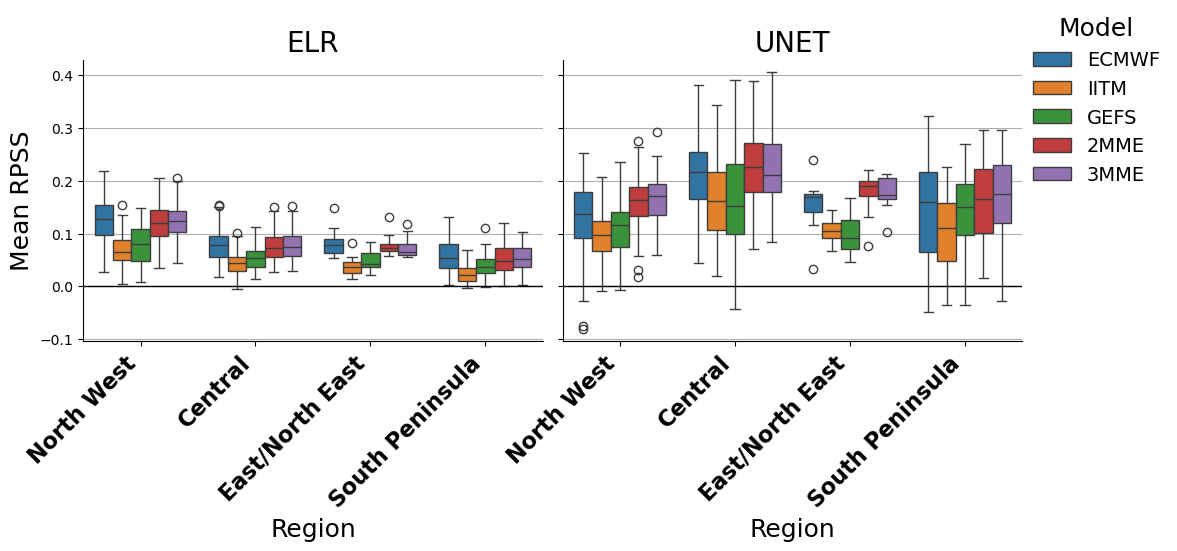

C:\Users\emile\AppData\Local\Temp\ipykernel_17220\1055731866.py:82: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right", fontsize=16, fontweight='bold')
C:\Users\emile\AppData\Local\Temp\ipykernel_17220\1055731866.py:82: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right", fontsize=16, fontweight='bold')


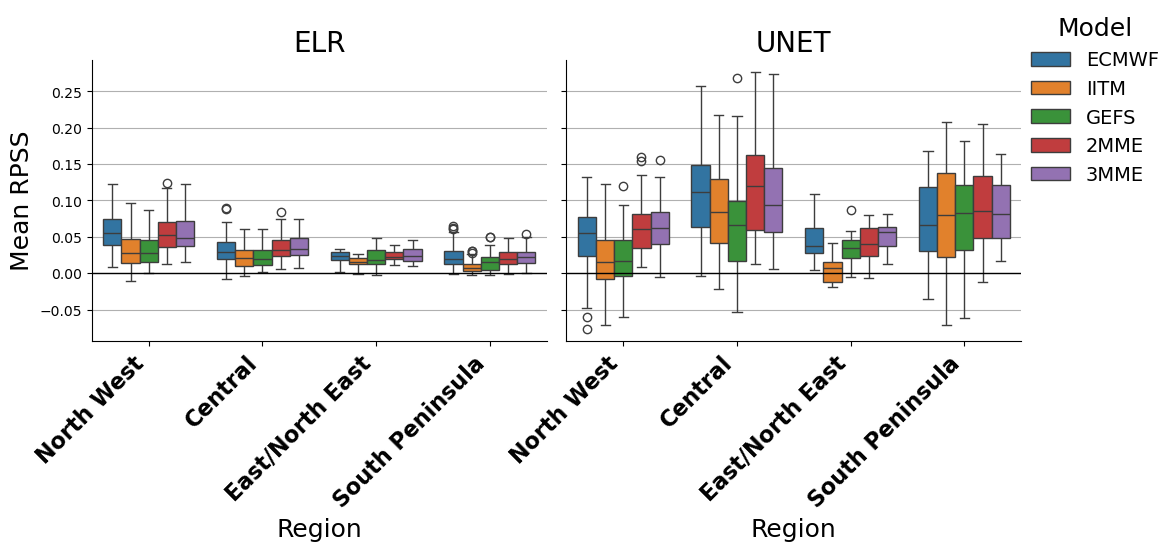

C:\Users\emile\AppData\Local\Temp\ipykernel_17220\1055731866.py:82: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right", fontsize=16, fontweight='bold')
C:\Users\emile\AppData\Local\Temp\ipykernel_17220\1055731866.py:82: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right", fontsize=16, fontweight='bold')


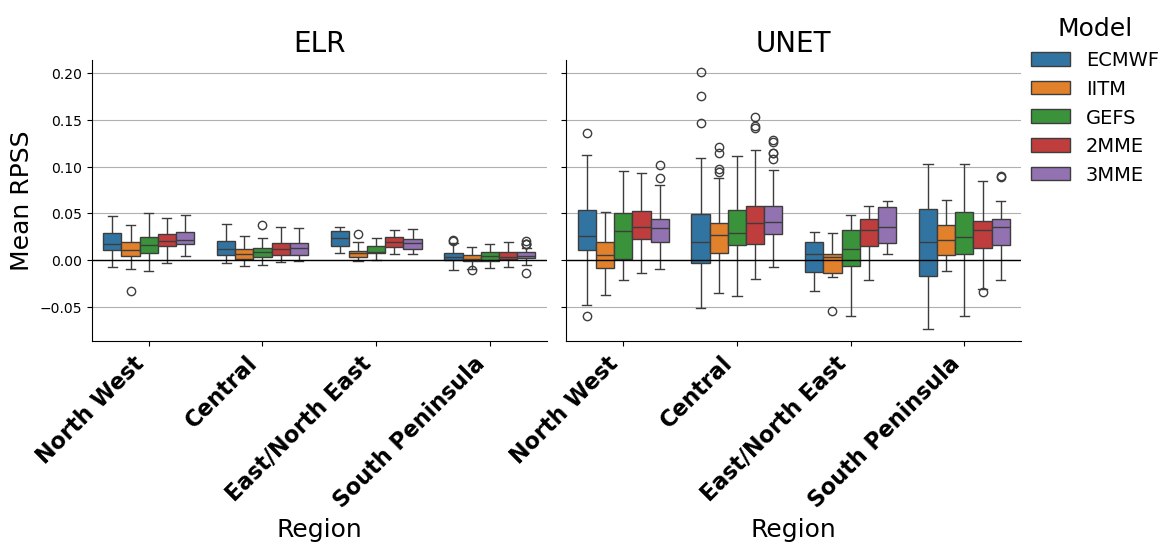

In [39]:
# Shortened region names
region_names = {
    1: 'South Peninsula',
    2: 'East/North East',
    3: 'North West',
    4: 'Central'
}



models = ["ECMWF", "IITM", "GEFS", "MME", "2MME"]
lead_time_order = ["week 1", "week 2", "week 3-4"]
architectures = ["ELR", "unet"]

# Subset to Common Period + MME only
df_mm = df[df["Period"].isin(["MME", "Common Period","2MME"])]

for lead_time in lead_time_order:
    plot_data = []

    for arch in architectures:
        for model in models:
            df_arch = df_mm[
                (df_mm["Architecture"] == arch) &
                (df_mm["Model"] == model) &
                (df_mm["Lead Time"] == lead_time)
            ]

            for _, row in df_arch.iterrows():
                rpss_values = row["RPSS"]
                region_mask = masks_common.get(model, None)
                if region_mask is None:
                    region_mask = masks_common["ECMWF"]  # Fallback to ECMWF mask if model-specific mask not found
                region_values = region_mask.values

                for i in range(rpss_values.shape[0]):
                    for j in range(rpss_values.shape[1]):
                        rpss_val = rpss_values[i, j]
                        region_id = region_values[i, j]

                        if np.isnan(rpss_val) or region_id not in region_names:
                            continue

                        plot_data.append({
                            "RPSS": rpss_val,
                            "Region": region_names[region_id],
                            "Model": model if model != "MME" else "3MME",
                            "Architecture": arch.upper(),
                            "Lead Time": lead_time
                        })

    # DataFrame for plotting
    plot_df = pd.DataFrame(plot_data)

    # Aggregate
    aggregated_df = plot_df.groupby(["Region", "Model", "Architecture"]).agg(
        RPSS_mean=("RPSS", "mean")
    ).reset_index()

    # Plot: one facet per architecture
    g = sns.FacetGrid(
        plot_df,
        col="Architecture",
        sharey=True,
        height=4,
        aspect=1.3
    )
    g.map_dataframe(
        sns.boxplot,
        x="Region",
        y="RPSS",
        hue="Model",
        hue_order=["ECMWF", "IITM", "GEFS", "2MME", "3MME"],
        palette="tab10"
    )

    g.set_titles(col_template="{col_name}", size=20)
    g.set_axis_labels("Region", "Mean RPSS", fontsize=18)

    for ax in g.axes.flat:
        ax.axhline(0, color="black", lw=1)
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right", fontsize=16, fontweight='bold')
        ax.grid(axis='y')

    g.add_legend(title="Model", title_fontsize=16, fontsize=14, loc='upper right')
    g._legend.set_title("Model", prop={"size": 18})
    g.fig.subplots_adjust(top=0.85)


    g.savefig(f"figures/barplots/MME_region_facet_{lead_time.replace(' ', '_')}.pdf", bbox_inches='tight', dpi=300)
    plt.show()
    plt.close()
